In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [6]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1,cache=True)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [7]:
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features. This is because each image is 28 x 28 (=784) pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black).

Let's take a look at one digit from the dataset. All we need to do is to grab an instance's feature vector and reshape it to a 28 x 28 array, and display it using Matplotlib's imshow() function.

Saving figure some_digit_plot


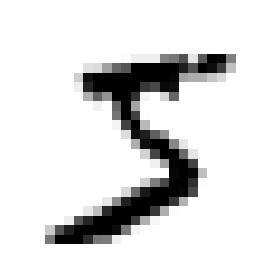

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [10]:
y[0]

'5'

Note that the label is a string.

In [11]:
y=y.astype(np.uint8)

In [12]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


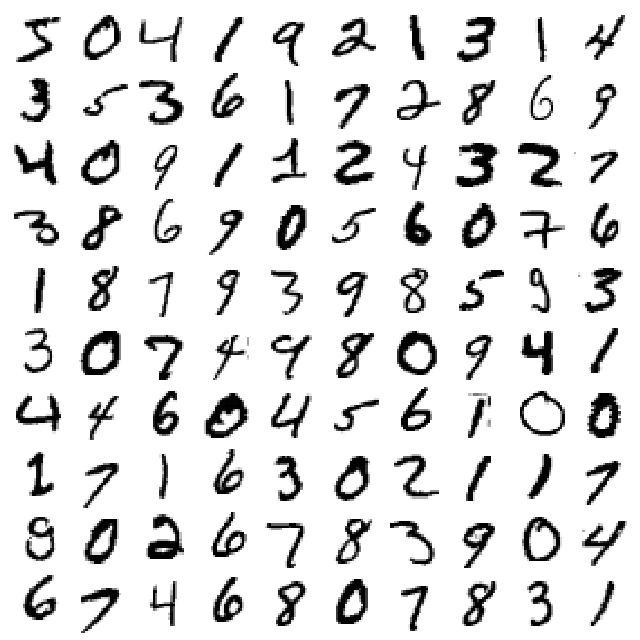

In [13]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [8]:
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# Training a Binary Classifier

Simplifying the problem by identifying only one digit 5

In [12]:
y_train_5=(y_train==5)     # True for all 5s, False for all other digits.
y_test_5=(y_test==5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Some hyperparameters will have a different default value in future versions of scikit-learn, such as max_iter and tol. To be future-proof, we explicitly set these hyperparameters.

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Using K-folds cross validation

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Using Statified K folds cross validation, where it performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration, the code creates a clone of the classifier, trains that clone on the training folds,and make prediction on the test folds.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9559
0.9559
0.96565


No let's try a very dumb classifier that just classifies every single image in the 'not 5' class

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy!!! This is simply because only 10% of the images are 5s, so if we always guess that an image is not 5, we will be right about 90% of the time.

This demonstrates why accuracy is not the preferred performance measure for classifiers, especially when we are dealing with skewed datasets(i.e when some classes are much more frequent than others) 

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

Just like cross_val_score() function, the cross_val_predict() performs K-folds cross validation, but instead of returning evaluation scores, it returns the predictions made on each test fold.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row of a confusion matrix represents an actual class, while each column represents a predicted class. 

The first row of the matrix considers non-5 images (the negative class): 

- 53,892 of them were correctly classified as non 5s (they are called true negatives), 

- while remaining 687 were wrongly classified as 5s (false positives).

The second row considers the images of 5s (the positive class):

- 1,891 were wrongly classified as non 5s (false negatives)

- while the remaining 3,530 were correctly classified as 5s (true positives).

In [21]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [22]:
cm=confusion_matrix(y_train_5,y_train_pred)
cm[1,1]/(cm[1,1]+cm[0,1])        # TP/(TP+FP)

0.8370879772350012

In [23]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [24]:
cm[1,1]/(cm[1,1]+cm[1,0])       # TP/(TP+FN)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called f1 score, in particular if we need a simple way to compare two classifiers.

f1 score is the harmonic mean of precision and recall.

f1 score = 2/((1/precision)+(1/recall))

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [26]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

The increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off. To understand this trade-off, let's look at how SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than the threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit Learn does not let us set the threshold directly, but it gives us the access to the decision scores that it uses to make the predictions. Instead of calling the classifier's predict() method, we can call its decision_function() method, which returns a score for each instance, and then use any threshold we want to make predictions based on those score.

In [27]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold=0
y_some_digit_pred=(y_scores>threshold)

In [29]:
y_some_digit_pred

array([ True])

In [30]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)

In [31]:
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.

Method to determine the right threshold:

In [32]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,
                          method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

Saving figure precision_recall_vs_threshold_plot


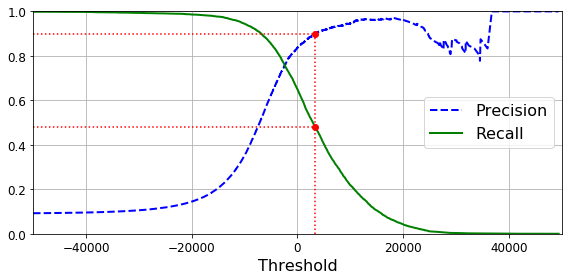

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

The precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when we raise the threshold (although in general it will go up). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth. 

Saving figure precision_vs_recall_plot


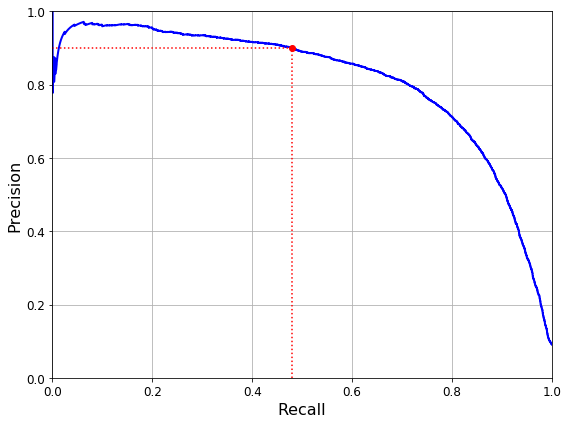

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

Let's search for the lowest threshold that gives us at least 90% precision. np.argmax() will give us the first index on the maximum value, which in this case means the first true value.

In [36]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [38]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

# ROC Curves

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision /recall curve, but instead of plotting precision verses recall, the ROC curve plots the true positive rate (another name for recall) against false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 - specificity

In [40]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

Saving figure roc_curve_plot


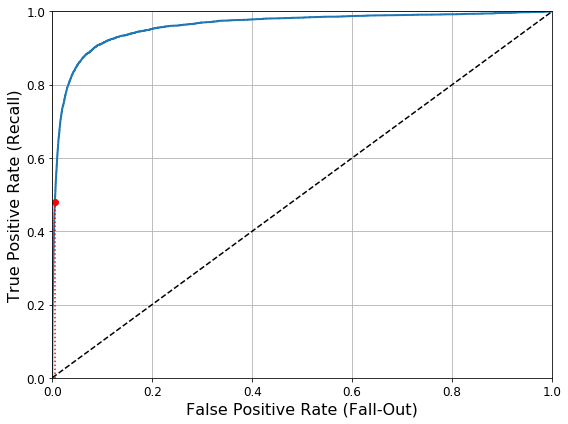

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away that line as possible (towards the top left corner).

One way to comapare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5 .

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Now, let's train a RandomForestClassifier and compare its ROC curve and ROC-AUC score to those of the SGDClassifier.

The RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit Learn classifiers generally have one or the other, or both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to a given class.

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                 method="predict_proba")

We set n_estimators=100 to be future proof.

In [44]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [45]:
y_probas_forest[:,1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

Let's use the positive class's probability as the score:

In [46]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,threshold_forest=roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


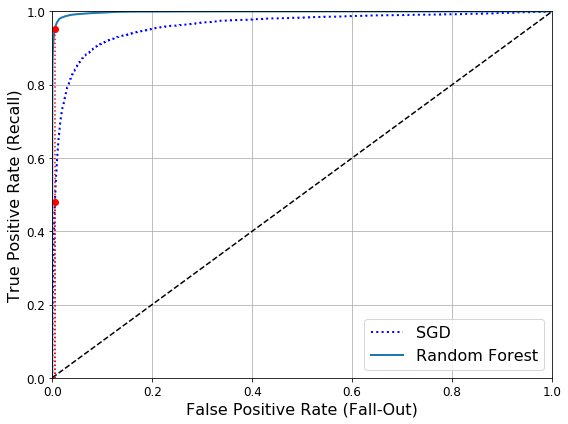

In [47]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [48]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [50]:
recall_score(y_train_5,y_train_pred_forest)

0.8662608374838591

# Multiclass classification

In [51]:
from sklearn.svm import SVC

svm_clf=SVC(gamma="auto",random_state=42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, Scikit-Learn used the OvO (one versus one) strategy (i.e to train a binary classifier for every pair of digits. If there are N classes, we need to train N x (N-1)/2 classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish. Some algorithms (such as the Support Vector Machine classifier) scale poorly with the size of the training set. For these algorithms, OvO is preferred because it is faster to train many classifiers on small training sets than few classifiers on large training sets.. Scikit-Learn detects when we try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR (one versus the rest) or OvO depending on the algorithm)

In [52]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]

5

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(gamma="auto",random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier:

In [60]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [61]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [62]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87082583, 0.87089354, 0.88628294])

In [63]:
class RandomClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [64]:
rand_clf=RandomClassifier()
cross_val_score(rand_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.0997 , 0.0965 , 0.09995])

We got an accuracy of 87% on all test folds using SGDClassifier. If we use a random classifier, we get an accuracy of approximately 10%. So this is not a bad score from SGDClassifier.

We can still do better by simply scaling the inputs. 

In [66]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [101]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

In [102]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

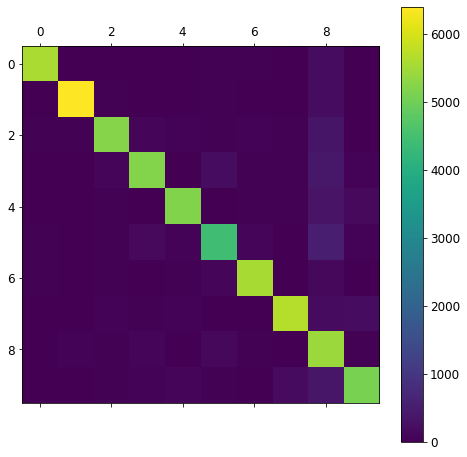

In [103]:
plot_confusion_matrix(conf_mx)

Saving figure confusion_matrix_plot


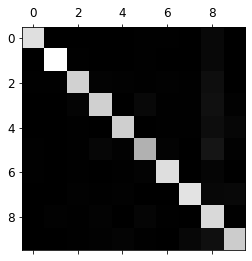

In [104]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

This confusion matrix looks pretty good,since most images are on the main diagonal, which means that they were classified correctly. The 5s looks slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or the classifier does not perform as well on 5s as on other digits.

We need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare the error rates instead of absolute number of errors.

In [105]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


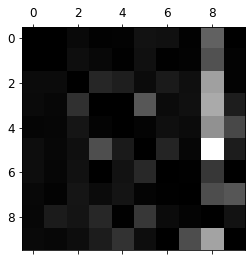

In [108]:
np.fill_diagonal(norm_conf_mx, 0)  #Fill the diagonal with zeros to keep only the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Now we can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The columns for class 8 are quite bright, which tells us that many images get misclassified as 8s. However, the row for class 8 is not bad, telling us that actual 8s in general get properly classified as 8s. The confusion matrix is not necessarily symmetrical. We can also see that 3s and 5s often get confused (in both direction).

Looking at this plot, it seems that our efforts should be spent on reducing the false 8s, as well as fixing the specific 3-5 confusion. For example,we can try to gather more training data for these digits. Or we can engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or we
can preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to gain insights on what our classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s:

Saving figure error_analysis_digits_plot


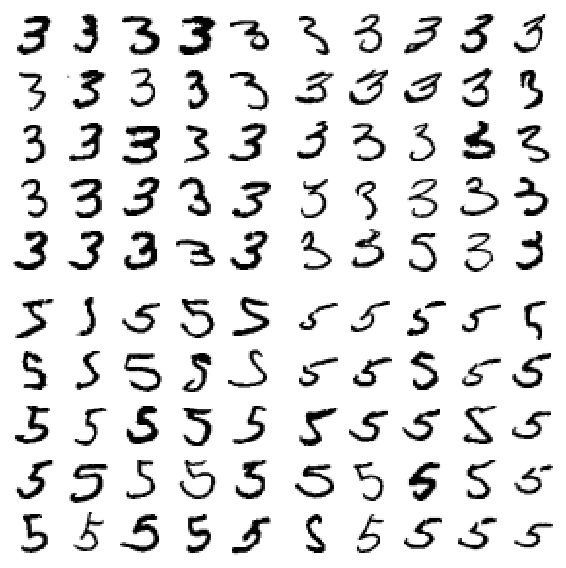

In [109]:
cl_a,cl_b=3,5
X_aa= X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab= X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba= X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb= X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 1st row and 2 nd column truly looks like a 3). However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier , which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them. 

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If we draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is
quite sensitive to image shifting and rotation. So one way to reduce the 3-5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

# Multilabel classification

A classification system that outputs multiple binary tags.

In [110]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large(7,8 or 9), and the second indicates whether or not it is odd.

In [111]:
knn_clf.predict([some_digit])

array([[False,  True]])

It gets it right! The digit 5 is indeed not large (False) and odd (True)

In [112]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605

# Multioutput Classification

In [113]:
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [120]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Saving figure noisy_digit_example_plot


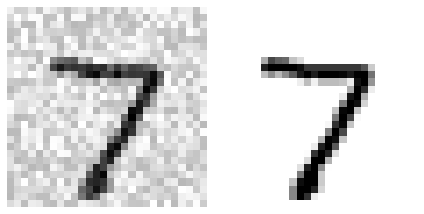

In [121]:
some_index=0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


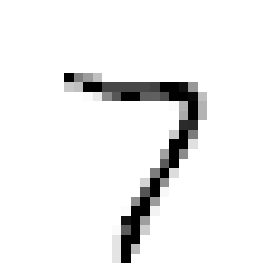

In [124]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# MNIST Classifier with over 97% Accuracy

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=13.2min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.2min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=13.1min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 26.2min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.9min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.7min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=12.7min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=12.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=12.7min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=12.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=12.8min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 390.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [10]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [11]:
grid_search.best_score_

0.9716166666666667

In [12]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# Data Augmentation

In [1]:
from scipy.ndimage.interpolation import shift

In [2]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

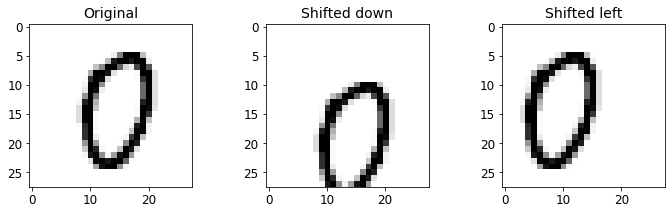

In [15]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [16]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [17]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)